<a href="https://colab.research.google.com/github/Goshective/Project_ML/blob/main/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных

In [4]:
!pip install kaggle
!pip install torch torchvision

In [5]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

# Move the uploaded file to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
# Download the dataset
!kaggle competitions download -c ml-intensive-yandex-autumn-2023

100% 988M/988M [00:12<00:00, 73.0MB/s]
100% 988M/988M [00:12<00:00, 81.5MB/s]


Перевод в zip

In [7]:
import zipfile

zip_file_path = "ml-intensive-yandex-autumn-2023.zip"
extracted_folder = "dataset"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_folder)

In [8]:
!ls -l dataset/data/

total 2204
drwxr-xr-x 2 root root 204800 Dec  4 09:09 test_images
-rw-r--r-- 1 root root 204908 Dec  4 09:09 train_answers.csv
drwxr-xr-x 2 root root 921600 Dec  4 09:09 train_images
drwxr-xr-x 2 root root 921600 Dec  4 09:10 train_lung_masks


## Перевод в датасеты

Находим пути, определяем константы

In [9]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Normalize
import torch

TEST_RANGE = 6920
TEST_MODE = 105106
NAMES = ["Normal", "Non_covid", "Covid_19"]

# Define paths
data_folder = "dataset/data"
train_images_folder = os.path.join(data_folder, "train_images")
train_masks_folder = os.path.join(data_folder, "train_lung_masks")
test_images_folder = os.path.join(data_folder, "test_images")
train_ans_path = os.path.join(data_folder, "train_answers.csv")

In [10]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_folder, transform=None, mode=None):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # load image from folder
        img_name = os.path.join(self.images_folder, f'img_{self.dataframe.iloc[idx, 0]}.png')
        image = Image.open(img_name).convert("L")

        if self.transform:
            image = self.transform(image)

        if self.mode == TEST_MODE:
            return image

        return image, self.dataframe["target_feature"][idx]

# Define transformations
transform = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5,), (0.25,))
])

# Create datasets
train_ans_pd = pd.read_csv(train_ans_path)
train_ans_tensor = torch.tensor(train_ans_pd["target_feature"].values) # to tensor

train_mask_dataset = CustomDataset(dataframe=train_ans_pd, images_folder=train_masks_folder, transform=transform)
train_image_dataset = CustomDataset(dataframe=train_ans_pd, images_folder=train_images_folder, transform=transform)

test_dataset = CustomDataset(dataframe=train_ans_pd, images_folder=test_images_folder, transform=transform, mode=TEST_MODE)

print(train_image_dataset[0][0].shape,
      train_image_dataset[0][1])

torch.Size([1, 256, 256]) 0


In [11]:
# for img in train_image_dataset:
#   print(type(img))
#   break
# train_image_tensor = torch.stack([item for item in train_image_dataset])
# train_image_tensor.shape

# train_set = torch.cat((train_image_tensor, train_ans_tensor), dim=1)

# train_set[0][1]

## Проверка данных

In [12]:
train_image_loader = DataLoader(train_image_dataset, batch_size=32, shuffle=True) # not using later
train_mask_loader = DataLoader(train_mask_dataset, batch_size=32, shuffle=False)

for img, ans in train_image_loader:
  print(img.shape)
  print(img[0], ans[31]) # because of batch
  break

for mask, ans in train_mask_loader:
  print(mask.shape)
  break

print(train_ans_tensor[0])

torch.Size([32, 1, 256, 256])
tensor([[[-0.3843, -1.1686, -1.5608,  ..., -1.3412, -1.1373, -1.0745],
         [-1.4039, -1.8118, -1.9529,  ..., -1.9843, -1.9373, -1.9216],
         [-1.8588, -1.9843, -1.9843,  ..., -2.0000, -2.0000, -2.0000],
         ...,
         [-1.9843, -1.9843, -2.0000,  ..., -2.0000, -2.0000, -2.0000],
         [-1.9843, -1.9843, -2.0000,  ..., -2.0000, -2.0000, -2.0000],
         [-1.9843, -1.9843, -2.0000,  ..., -2.0000, -2.0000, -2.0000]]]) tensor(1)
torch.Size([32, 1, 256, 256])
tensor(0)


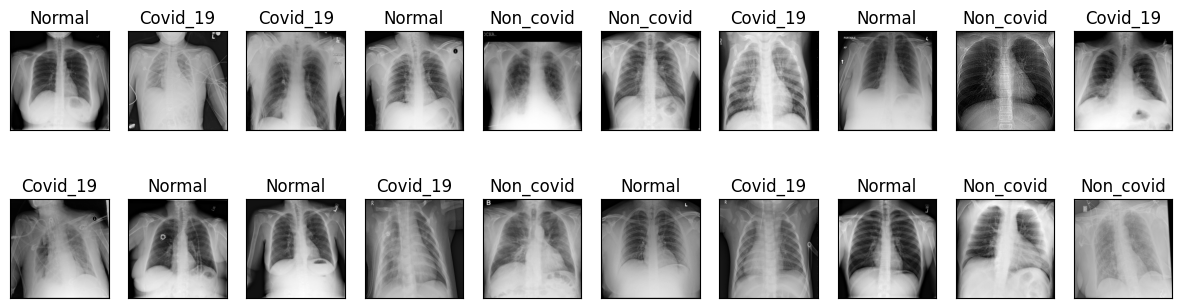

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

for i, (img, ans) in enumerate(train_image_dataset):
    if i == 20:
      break
    plt.subplot(2, 10, i + 1)
    plt.imshow(img.permute(1, 2, 0) * 0.25 + 0.5, cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.title(NAMES[ans])

plt.show()

# Baseline решение

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Модели

* model_cur - текущая модель

**Игрушечная модель**

In [44]:
from torch import nn
from torchsummary import summary

model_cur = nn.Sequential(
    nn.Flatten(start_dim=-3),
    nn.Linear(in_features=256**2, out_features=3),
    nn.Softmax(dim=1),
)

print(summary(model_cur, (1, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 65536]               0
            Linear-2                    [-1, 3]         196,611
           Softmax-3                    [-1, 3]               0
Total params: 196,611
Trainable params: 196,611
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.50
Params size (MB): 0.75
Estimated Total Size (MB): 1.50
----------------------------------------------------------------
None


In [45]:
model_1 = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(4, 4), # -> (16, 256, 256) -> (16, 64, 64)

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(4, 4), # -> (32, 64, 64) -> (32, 16, 16)
    nn.Dropout2d(p=0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(4, 4), # -> (64, 16, 16) -> (64, 4, 4)
    nn.Dropout2d(p=0.2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(4, 4), # -> (128, 4, 4) -> (128, 1, 1)

    nn.Flatten(start_dim=-3),
    nn.Linear(in_features=128, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=3),
    nn.Softmax(dim=1),
)

print(summary(model_1, (1, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
       BatchNorm2d-3         [-1, 16, 256, 256]              32
         MaxPool2d-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           4,640
              ReLU-6           [-1, 32, 64, 64]               0
       BatchNorm2d-7           [-1, 32, 64, 64]              64
         MaxPool2d-8           [-1, 32, 16, 16]               0
         Dropout2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
        MaxPool2d-13             [-1, 64, 4, 4]               0
        Dropout2d-14             [-1, 6

Проверка формата входа и выхода модели

In [46]:
rand_tensor = torch.rand((32, 1, 256, 256))
pred = model_cur(rand_tensor)
pred.shape

torch.Size([32, 3])

## Настройка цикла обучения

### Разделение выборки

In [47]:
from torch.utils.data import random_split

train_set, valid_set = random_split(train_image_dataset, (0.95, 0.05))

train_set[0]

(Image([[[-0.1333, -0.4157, -0.6353,  ...,  0.8078,  0.9176,  0.7608],
         [-1.5137, -1.7333, -1.8745,  ...,  0.5412,  0.6353,  0.5098],
         [-1.9216, -1.9686, -1.9686,  ..., -0.2588, -0.0392, -0.0078],
         ...,
         [-1.9373, -1.9373, -1.9373,  ..., -1.4196, -1.1059, -0.6196],
         [-1.9216, -1.9373, -1.9373,  ..., -1.3569, -1.0588, -0.6353],
         [-1.9216, -1.9216, -1.9216,  ..., -1.2471, -0.9804, -0.6510]]], ),
 2)

### Константы для обучения

In [48]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_LOG_ITERS = 200

metrics_hist = {"train":
                          {"accuracy": [], "loss": [], "f1": []},
                "valid":
                          {"accuracy": [], "loss": [], "f1": []}
                }


optimizer = torch.optim.SGD(model_cur.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

for X,y in train_loader:
  print(X.shape, y.shape)
  print(X[0].shape)
  break

torch.Size([32, 1, 256, 256]) torch.Size([32])
torch.Size([1, 256, 256])


In [49]:
!pip install pytorch-ignite

In [50]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall, Fbeta

for a,b in train_loader:
  print(a.shape)
  ppp = model_cur(a)
  ppp2 = ppp.squeeze()
  print(b.shape)
  print("result of model:", ppp.shape, "->", ppp2.shape)
  criterion(ppp2, b)
  break

trainer = create_supervised_trainer(model_cur, optimizer, criterion, device)

precision = Precision(average=False)
recall = Recall(average=False)
F1 = Fbeta(beta=1.0, precision=precision, recall=recall, average=True) # artificial f1

metrics = {
    "loss": Loss(criterion),
    "accuracy": Accuracy(),
    "f1": F1
}

train_evaluator = create_supervised_evaluator(model_cur, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model_cur, metrics=metrics, device=device)

torch.Size([32, 1, 256, 256])
torch.Size([32])
result of model: torch.Size([32, 3]) -> torch.Size([32, 3])


In [51]:
# print(F1(np.array([0.001, 0.9, 0.099])))

### Лог-функции и вывод графиков

In [52]:
from IPython.display import clear_output
import numpy as np

def show_metrics(hist: dict):  #, test_f):
    clear_output()

    names = ['loss', 'accuracy', 'f1']
    modes = ['train', 'valid']

    plt.figure(figsize=(24,12))
    for i, name in enumerate(names): # shows plot for every metric

        plt.subplot(1, len(names), i+1)
        plt.title(name.capitalize())

        for mode in modes: # in train and valid mode
            range_metric = np.arange(len(hist[mode][name]))

            plt.plot(range_metric, hist[mode][name],
                    label=f"{mode} {name} = {hist[mode][name][-1]:.5f}")

        plt.legend()

        plt.yscale('log')
        plt.grid()

    plt.show()

In [53]:
from ignite.engine import Events


def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output}")

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=NUM_LOG_ITERS), log_iter_loss)


def compute_epoch_results(engine):
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)


def log_epoch_results(engine, label=""):
    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])

    for m, v in engine.state.metrics.items(): # lists each metric under consideration
        metrics_hist[label.lower()][m].append(v)


    # func is calling 2 times for train and valid
    if len(metrics_hist['valid']['loss']) == len(metrics_hist['train']['loss']):

        # no graphics with only 1 point
        if len(metrics_hist['valid']['loss']) > 1:

            show_metrics(metrics_hist)

        print(f"{temp_results[-1][0]} Res:", temp_results[-1][1])
        print(f"{label} Res:", result)
        temp_resulst = []

    else:
        temp_results.append((label, result))

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")
temp_results = []

LR Scheduler

In [54]:
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, print_lr)

## Обучение

Обновите все предыдущие ячейки перед запуском (либо запустите "Baseline решение", как одну свёрнутую ячейку)

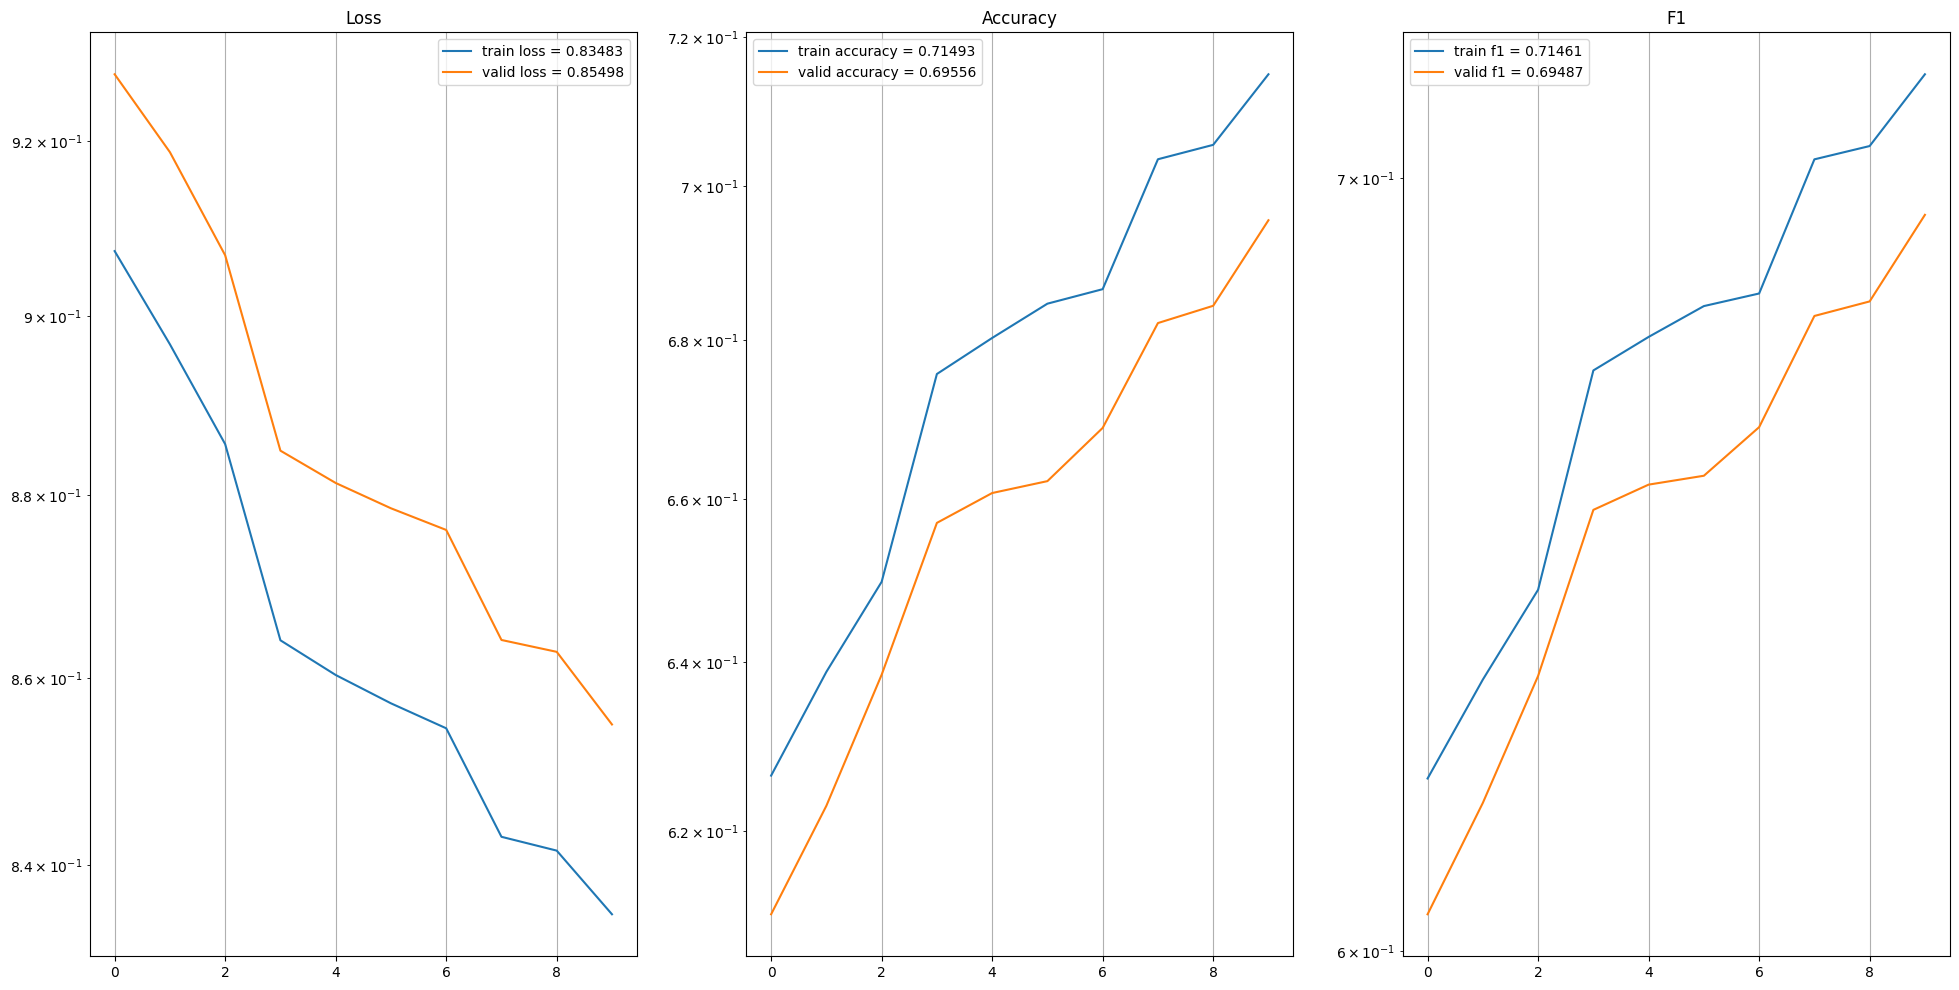

Train Res: loss = 0.8348342318469786, accuracy = 0.7149317738791423, f1 = 0.7146147653695801
Valid Res: loss = 0.8549763997395833, accuracy = 0.6955555555555556, f1 = 0.6948698801332442
Optimizer learning rate = 0.000125


State:
	iteration: 8020
	epoch: 10
	epoch_length: 802
	max_epochs: 10
	output: 0.8026378154754639
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [55]:
trainer.run(train_loader, NUM_EPOCHS)

## Предсказания для теста

In [56]:
print(test_dataset[0].shape)

model_cur.eval()
y_test = []
for i in range(TEST_RANGE):
    x = torch.stack([test_dataset[i],]) # convert to model input shape
    y_pred = torch.argmax(model_cur(x))
    y_test.append(y_pred.item())

print(len(y_test), y_test[:2])

torch.Size([1, 256, 256])
6920 [2, 2]


In [57]:
y_dataset = pd.DataFrame({'target_feature': y_test})
y_dataset

,target_feature
0,2
1,2
2,1
3,2
4,0
...,...
6915,2
6916,1
6917,0
6918,2


In [58]:
# from google.colab import files

y_dataset.to_csv('df.csv', index_label='id')
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>